In [1]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

## Sentiment Labelled Sentences Data Set 

This data set consists of 3000 sentences which come from reviews from imdb.com, amazon.com, and yelp.com. The sentences are labeled either '1' for a positive review or '0' for a negative review. We will find it useful to replace the negative review labels with '-1' instead of '0'.

To transform this prediction problem into one amenable to linear classification, we will first need to preprocess the text data. The general steps for doing this are:

1. Remove punctuation and numbers.
2. Transform all words to lower-case.
3. Remove _stop words_.

In [2]:
## Read in the data set.
with open("sentiment_labelled_sentences/full_set.txt") as f:
    content = f.readlines()
    
## Remove leading and trailing white space
content = [x.strip() for x in content]

## Separate the sentences from the labels
sentences = [x.split("\t")[0] for x in content]
labels = [x.split("\t")[1] for x in content]

## Transform the labels from '0 v.s. 1' to '-1 v.s. 1'
y = np.array(labels, dtype='int8')
y = 2*y - 1

## full_remove takes a string x and a list of characters removal_list 
## returns x with all the characters in removal_list replaced by ' '
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

## Remove digits
digits = [str(x) for x in range(10)]
digit_less = [full_remove(x, digits) for x in sentences]

## Remove punctuation
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]

## Make everything lower-case
sents_lower = [x.lower() for x in punc_less]

### Stop words

Stop words are words that are filtered out because they are believed to contain no useful information for the task at hand. These usually include articles such as 'a' and 'the', pronouns such as 'i' and 'they', and prepositions such 'to' and 'from'. We have put together a particular set of stop words, but these are by no means comprehensive.

In [3]:
## Define our stop words
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

## Remove stop words
sents_split = [x.split() for x in sents_lower]
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

In [4]:
sents_processed[0:10]

['so there is no way for me plug in here in us unless go by converter',
 'good case excellent value',
 'great for jawbone',
 'tied charger for conversations lasting more than minutes major problems',
 'mic is great',
 'have jiggle plug get line up right get decent volume',
 'if you have several dozen or several hundred contacts then imagine fun sending each them one by one',
 'if you are razr owner you must have this',
 'needless say wasted my money',
 'what waste money and time']

### Bag of words

In order to use linear classifiers on our data set, we need to transform our textual data into numeric data. The classical way to do this is known as the _bag of words_ representation. 

In this representation, each word is thought of as corresponding to a number in $\{1, 2, \ldots, V \}$ where $V$ is the size of our vocabulary. And each sentence is represented as a vector $x \in \mathbb{R}^V$, where $x_i$ is the number of times that word $i$ occurred in the sentence.

To do this transformation, we will make use of the CountVectorizer class in scikit-learn. We will cap the number of features at 4500, meaning a word will make it into our vocabulary only if it is one of the 4500 most common words in our corpus. This is often a useful step as it can weed out spelling mistakes and words which occur too infrequently to be useful.

Finally, we will also append a '1' to the end of each vector to allow our linear classifier to learn a bias term.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

## Transform to bag of words representation.
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 4500)
data_features = vectorizer.fit_transform(sents_processed)

## Append '1' to the end of each vector.
p_mat = data_features.toarray()
data_mat = np.ones((p_mat.shape[0], p_mat.shape[1]+1))
data_mat[:,:-1] = p_mat

In [6]:
## Split the data into testing and training sets
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds = list(set(range(len(labels))) - set(test_inds))

train_data = data_mat[train_inds,]
train_labels = y[train_inds]

test_data = data_mat[test_inds,]
test_labels = y[test_inds]

print("train data: ", train_data.shape)
print("test data: ", test_data.shape)

('train data: ', (2500, 4501))
('test data: ', (500, 4501))


## Logistic Regression

In logistic regression, we are trying to find a weight vector $w \in \mathbb{R}^d$ that minimizes the logistic loss. For a set of examples $(x_1, y_1), \ldots, (x_n, y_n)$, the empirical logistic loss looks like

$$ L(w) = \sum_{i=1}^n L(w; \ x_i, y_i).$$

where

$$ L(w; \ x, y) = \log(1 + e^{-y \ \langle w, x \rangle}).$$

For each data point $x \in \mathbb{R}^d$, we can think of $w$ as assigning a probability to the event that $x$ is positive via the logistic sigmoid:

$$ Pr(x \text{ is positive}; \ w) = \sigma(\langle w, x\rangle) $$

where

$$ \sigma(t) = \frac{1}{1 + e^{-t}} .$$

In [7]:
## Logistic sigmoid
def sigmoid(w, x):
    return 1.0/(1.0 + np.exp(-1.0 * np.dot(w, x)))

## Apply logistic sigmoid to all rows in data, classify as positive if probability > 0.5
def classify_data(w, data):
    preds = np.array([sigmoid(w,data[i,]) for i in range(data.shape[0])])
    return preds > 0.5

## Stochastic Gradient Descent

We now turn to learning the weight vector $w$. We will use a simple but powerful algorithm known as _stochastic gradient descent_ or SGD, which works for any convex loss function. Roughly the algorithm is as follows.

* Initialize $w = \vec{0}$.
* Repeat until convergence:
     * Shuffle the order of the data.
     * For each data point (x_i, y_i):
         * Update $w = w + \eta \ \nabla L(w; \ x_i, y_i)$.

Here $eta$ is the _learning rate_. We will simply set it to be some small constant. $\nabla L(w; \ x, y)$ is the _gradient_ of the loss function $L(w; \ x, y)$, i.e. the vector whose $j$-th component is the partial derivative $\frac{\partial}{\partial w_j} L(w; \ x, y)$. For the logistic loss, these partial derivatives look like the following.

$$ \frac{\partial}{\partial w_j} L(w; \ x, y) = \frac{-y \ x_j \ e^{-y \langle w, x \rangle}}{1 + e^{-y \langle w, x \rangle}} $$

We are now ready to write out sgd for logistic regression.

In [8]:
## Compute gradient on example (x,y)
def log_grad(w, x, y):
    exp_val = np.exp(-1.0*y*np.dot(w, x))
    return (-1.0*y*x*exp_val)/(1 + exp_val)

## SGD algorithm
def sgd(data, labels, eta=0.1):
    dist = 10.0 # Distance will track how much w changes between iterations
    w = np.zeros(data.shape[1]) # Initialize w to be zero vector
    j = 0
    ## `Convergence' for us is when our weight vector w does not change too much after an iteration
    loss = []
    while(dist > .1): 
        w_old = w
        order = np.random.permutation(len(labels))
        for i in order:
            grad = log_grad(w, data[i,], labels[i])
            w = w - eta*grad
        logscore = 0.0
        for i in order:
            logscore = logscore + np.log(1 + np.exp(-1.0*labels[i]*(np.dot(w,data[i,]))))
        loss.append(logscore)
        dist = np.linalg.norm(w-w_old)
        ## Print out after every 100 iterations to see how convergence looks.
        if(j%100 == 0):
            print(j, " : ", dist, logscore)
        j += 1
    return w, loss

In [9]:
## Run SGD on training data
w, loss = sgd(train_data, train_labels)

## Get predictions on test_data
pred_labels = classify_data(w, test_data)

## Compute test error
num_errors = np.sum(pred_labels != (test_labels > 0.0))
print("test error: ", float(num_errors)/len(test_labels))

(0, ' : ', 8.3169192975157866, 1003.5851657910328)
(100, ' : ', 0.29700571636180628, 82.398743314228994)
(200, ' : ', 0.16069296586299661, 46.508606096860923)
(300, ' : ', 0.10812164070179603, 32.910951711541244)
('test error: ', 0.152)


In [10]:
pred_labels = np.array([sigmoid(w,test_data[i,])-0.5 for i in range(test_data.shape[0])])

In [11]:
scores = pred_labels * test_labels
I = np.argsort(scores)

In [12]:
for i in range(0,100):
    j = test_inds[I[i]]
    print sentences[j], y[j] 

We made the drive all the way from North Scottsdale... and I was not one bit disappointed! 1
The pairing of the two devices was so easy it barely took a couple minutes before I started making calls with the voice dialing feature. 1
The loudspeaker option is great, the bumpers with the lights is very ... appealing. -1
I usually don't like headbands but this one is very lightweight & doesn't mess up my hair. 1
I was able to do voice dialing in the car with no problem. 1
its a little geeky but i think thats its sex on toast and it rocks and oozes sex right down to its battery embedded sleek stylish leather case. 1
I don't think you will be disappointed.   1
If you check the director's filmography on this site you will see why this film didn't have a chance.   -1
Now the burgers aren't as good, the pizza which used to be amazing is doughy and flavorless. -1
Because both ears are occupied, background is not distracting at all. 1
Actually, the graphics were good at the time.   1
You won't be

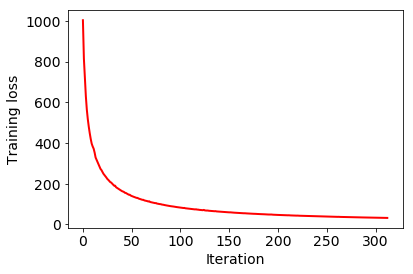

In [13]:
# Show how the training loss decreases over iterations (each a full pass over the data)
plt.plot(loss, linewidth=2, color='red')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Training loss', fontsize=14)
plt.show()

### Scikit-learn implementation

Scikit-learn has a fast implementation of SGD capable of fitting a linear classifier on logistic loss. Due to the randomness in the algorithm, the weight vectors found in SGD do not always have precisely the same performance.

In [14]:
from sklearn.linear_model import SGDClassifier

## Fit logistic classifier on training data
clf = SGDClassifier(loss="log")
clf.fit(train_data, train_labels)

## Get predictions on test data
preds_sk = clf.predict(test_data)

## Compute errors
sk_errors = np.sum((preds_sk > 0.0) != (test_labels > 0.0))
print("sklearn test error: ", float(sk_errors)/len(test_labels))

('sklearn test error: ', 0.174)


### The margin

Because the output of logistic regression on a data point can be viewed as a probability, we might expect our classifier to be more confident on those points for which its prediction is closer to 0 or 1. Thus, we might expect our classifier to do better if we allow it to abstain from classifying a data point if its prediction lies within $\gamma$ of 0.5. 

In [15]:
## Return error of predictions that lie in intervals [0, 0.5 - gamma) and (0.5 + gamma, 1]
def margin_errors(w, test_data, test_labels, gamma):
    ## Compute probability on each test point
    preds = np.array([sigmoid(w, test_data[i,]) for i in range(test_data.shape[0])])
    
    ## Find data points for which prediction is at least gamma away from 0.5
    margin_inds = np.where((preds > (0.5+gamma)) | (preds < (0.5-gamma)))[0]
    
    ## Compute error on those data points.
    num_errors = np.sum((preds[margin_inds] > 0.5) != (test_labels[margin_inds] > 0.0))
    return float(num_errors)/len(margin_inds)

In [16]:
## Return error of predictions that lie in intervals [0, 0.5 - gamma) and (0.5 + gamma, 1]
def margin_percentiles(w, test_data, test_labels, gamma):
    ## Compute probability on each test point
    preds = np.array([sigmoid(w, test_data[i,]) for i in range(test_data.shape[0])])
    
    ## Find data points for which prediction is at least gamma away from 0.5
    margin_inds = np.where((preds > (0.5+gamma)) | (preds < (0.5-gamma)))[0]
    
    return float(len(margin_inds))

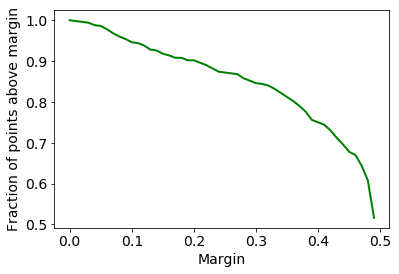

In [17]:
gammas = np.arange(0,0.5,0.01)
f = np.vectorize(lambda g: margin_percentiles(w, test_data, test_labels, g))
sz = f(gammas)
plt.plot(gammas, f(gammas)/500.0, linewidth=2, color='green')
plt.xlabel('Margin', fontsize=14)
plt.ylabel('Fraction of points above margin', fontsize=14)
plt.show()

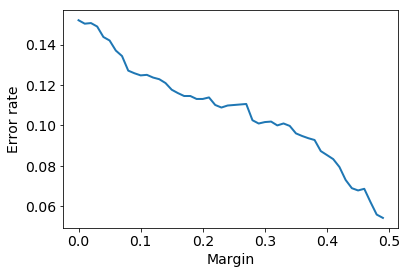

In [18]:
import matplotlib.pyplot as plt

## Create grid of gamma values
gammas = np.arange(0, 0.5, 0.01)

## Compute margin_errors on test data for each value of g
f = np.vectorize(lambda g: margin_errors(w, test_data, test_labels, g))

## Plot the result
plt.plot(gammas, f(gammas), linewidth=2)
plt.ylabel('Error rate', fontsize=14)
plt.xlabel('Margin', fontsize=14)
plt.show()

## Words with large influence

Because we are our model is linear, interpreting it is relatively straightforward.

In [19]:
## Convert vocabulary into a list:
vocab = np.array([z[0] for z in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])])

## Get indices of sorting w
inds = np.argsort(w)

## Words with large negative values
neg_inds = inds[0:50]
print("Highly negative words: ")
print([str(x) for x in list(vocab[neg_inds])])

## Words with large positive values
pos_inds = inds[-49:-1]
print("Highly positive words: ")
print([str(x) for x in list(vocab[pos_inds])])

Highly negative words: 
['disappointment', 'sucked', 'bit', 'stupid', 'poor', 'falls', 'graphics', 'hated', 'missing', 'average', 'appalling', 'doesn', 'dirty', 'garbage', 'buying', 'worst', 'sorry', 'directing', 'dislike', 'lacks', 'disappointing', 'didn', 'fails', 'awful', 'not', 'avoid', 'starter', 'mess', 'unrecommended', 'sucks', 'roasted', 'bland', 'return', 'slow', 'wasn', 'year', 'don', 'overpriced', 'weak', 'annoying', 'difficult', 'hate', 'hours', 'down', 'lame', 'started', 'fair', 'piece', 'crap', 'plan']
Highly positive words: 
['disappoint', 'easily', 'struggle', 'prompt', 'hands', 'joy', 'pleased', 'properly', 'wow', 'bachi', 'mouth', 'soon', 'interesting', 'fast', 'restaurant', 'best', 'recommendation', 'score', 'incredible', 'definitely', 'enjoyed', 'tasty', 'amazing', 'game', 'check', 'love', 'package', 'fantastic', 'wonderful', 'awesome', 'excellent', 'plus', 'works', 'complaints', 'nice', 'delicious', 'perfect', 'predictable', 'believable', 'liked', 'loved', 'soundtr